---
title: Lecture 4
subtitle: Transforms
date: 2024-09-011
downloads:
  - file: 04_lecture.ipynb
    title: 04_lecture.ipynb
  - file: ../assets/04_lecture.pdf
    title: 04_lecture.pdf
---

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

Image transforms are used to isolate patterns of interest, represent data in a more compact form, and are reversible.

The learning objectives are:
- DFT for images
- DCT
- Haramord-Walsh transform
- Haar transform

## DFT for images

The [Fourier transform](wiki:Fourier_transform)[^1] is an integral transform that takes a function as input and outputs another function that describes the extent to which various frequencies are present in the original function. It is defined in [Equation (%s)](#equ-FT) The output of the transform is a complex-valued function of frequency.

:::{prf:definition} Fourier Transform
:nonumber: True
$$
\label{equ-FT}
\hat{f}(\zeta) = \int^{\infty}_{-\infty} f(x)e^{-i2\pi\zeta x} dx
$$

where,

- $\hat{f}(\zeta)$ is the frequency-domain representation of the function $f(x)$
- $\zeta$ is the frequency variable
- $f(x)$ is the original function in the time or spatial domain
- $x$ is the time or spatial variable 
:::

The [DFT](wiki:Discrete_Fourier_transform) is the Fourier transform applied to discrete data. It operates on a finite sequence of equally spaced samples from a signal and is defined in [Equation (%s)](#equ-DFT).

:::{prf:definition} DFT
:nonumber: True
$$
\label{equ-DFT}
X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-i \frac{2\pi}{N} k n}
$$

where,

- $X[k]$ is the k-th frequency component of the input signal $x[n]$
- $k$ is the frequency index
- $x[n]$ is the signal input in the time or spatial domain
- $n$ is the sample index
:::

The [FFT](wiki:Fast_Fourier_transform) is an efficient algorithm to compute the DFT. It reduces the computational complexity of the DFT from $O(N^{2})$ to $O(N\log{N})$.

:::{note}
When using `np.fft.fft()` the function performs the DFT via the FFT algorithm.
:::

[^1]: The accompanying video does a great job describing the Fourier transform.
    :::{iframe} https://www.youtube.com/embed/spUNpyF58BY?si=siTxY9oE7mT2z1oX
    :::

### 1-D Example

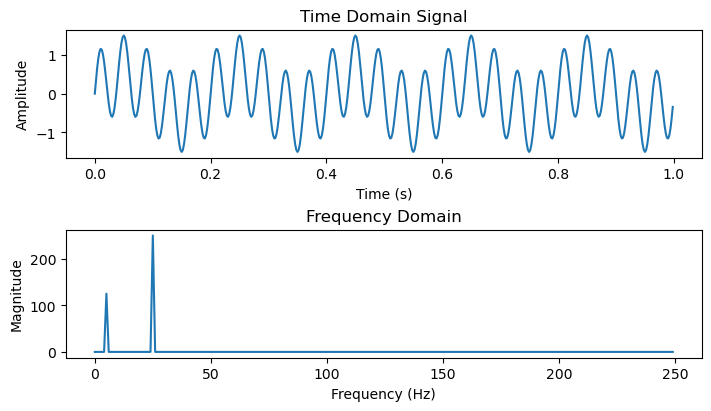

In [36]:
# define the time domain signal
sampling_rate = 500 # samples per second
T = 1.0 / sampling_rate # seconds per sample (sampling interval)
duration = 1.0
N = int(duration * sampling_rate) # samples
x = np.linspace(0.0, duration, N, endpoint=False) # False to account for 0-index

# create a signal composed of two difference sine waves
freq1 = 5
freq2 = 25
signal = 0.5 * np.sin(2.0 * np.pi * freq1 * x) + 1 * np.sin(2.0 * np.pi * freq2 * x)

# compute the DFT using FFT
fft_values = np.fft.fft(signal)

# real-valued signals have symmetric FTs, so just take the positive half of the spectrum
fft_mag = np.abs(fft_values)[:N // 2]
freqs = np.fft.fftfreq(N, T)[:N // 2]

# plot the results
fig, axs = plt.subplots(2, 1, figsize=(7,4), layout='constrained')
axs[0].plot(x, signal); axs[0].set_title('Time Domain Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[1].plot(freqs, fft_mag)
axs[1].set_title('Frequency Domain')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude')
plt.show()

__Takeaways__

The time domain signal looks complex because of the superposition of two sine waves with different frequencies. In the frequency domain it is clear that the signal is composed of two frequencies (e.g., 5 Hz and 25 Hz). Lastly, the magnitude of the peaks in the frequency domain gives information on the relative strength of each frequency in the original signal.